In [7]:
%matplotlib inline
import numpy as np

import nengo
import nengo.utils.function_space as fs

In [65]:
def gaussian(points, mean, sd):
    return np.exp(-(points-mean)**2/(2*sd**2))

n_neurons = 100
domain = fs.uniform_cube(1, d=0.01)
fns = fs.gen_funcs(gaussian, fs.gen_args(n_neurons, nengo.dists.Uniform(-1,1), nengo.dists.Uniform(0.1,0.7)),
                        domain)

In [29]:
fns.shape

(100, 200)

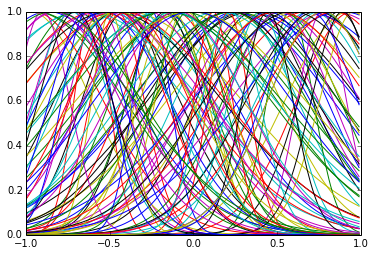

In [31]:
import pylab

pylab.plot(domain, fns.T)
pylab.show()


In [27]:
obj = fs.SVD_FS(fns, d=0.01, domain_dim=1, n_basis=20)

In [44]:
input_func = fs.sample_comb(gaussian, 4, domain, nengo.dists.Uniform(-1, 1), nengo.dists.Uniform(0.1, 0.1))

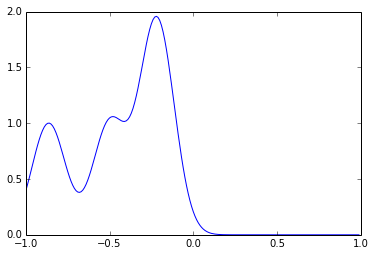

In [45]:
pylab.plot(domain, input_func)

In [48]:
n_eval_points = 2000
eval_points = fs.sample_eval_points(gaussian, obj, n_eval_points, 4, domain, 
                                    nengo.dists.Uniform(-1,1), nengo.dists.Uniform(0.1, 0.2))

In [62]:
input_func = fs.sample_comb(gaussian, 4, domain, nengo.dists.Uniform(-1, 1), nengo.dists.Uniform(0.1, 0.1))
signal_coeffs = obj.project(input_func)
print signal_coeffs

[-0.72011277  0.26491037 -0.12876718 -0.5949989   0.07559833  0.03988487
  0.02936785 -0.00776971 -0.12133982 -0.13299288  0.06460784  0.05455718
 -0.03965301  0.01982234 -0.03432624  0.00526258 -0.01057707  0.00113405
  0.00909202  0.00759423]


In [51]:
print signal_coeffs

[-0.74051018  0.58499154  0.0161206  -0.27551141 -0.09553273 -0.28439626
  0.11671977 -0.16845737 -0.04523937 -0.1325139   0.0670308  -0.14646334
 -0.03714185  0.03431211 -0.0338554  -0.07034616 -0.00482062 -0.02155986
 -0.00153385  0.0023969 ]


In [67]:

model = nengo.Network()
with model:
    ens = nengo.Ensemble(n_neurons=n_neurons, dimensions=obj.n_basis,
                         encoders = obj.encoders(), radius=np.linalg.norm(signal_coeffs),
                         eval_points=eval_points)
    stim = nengo.Node(signal_coeffs)
    nengo.Connection(stim, ens)
    
    p = nengo.Probe(ens, synapse=0.1)

In [68]:
sim = nengo.Simulator(model)
sim.run(0.2)

Simulation finished in 0:00:01.                                                 


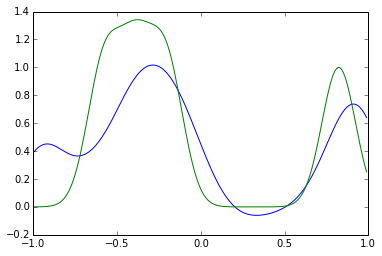

In [70]:
pylab.plot(domain, obj.reconstruct(sim.data[p][-1]))
pylab.plot(domain, input_func)